Train dataset shape:  (370703, 24)
Test dataset shape:  (92676, 23)

Missing values in train data:
 id            0
trans_num     0
trans_date    0
trans_time    0
unix_time     0
category      0
amt           0
cc_num        0
first         0
last          0
gender        0
street        0
city          0
state         0
zip           0
lat           0
long          0
city_pop      0
job           0
dob           0
merchant      0
merch_lat     0
merch_long    0
is_fraud      0
dtype: int64

Missing values in test data:
 id            0
trans_num     0
trans_date    0
trans_time    0
unix_time     0
category      0
amt           0
cc_num        0
first         0
last          0
gender        0
street        0
city          0
state         0
zip           0
lat           0
long          0
city_pop      0
job           0
dob           0
merchant      0
merch_lat     0
merch_long    0
dtype: int64


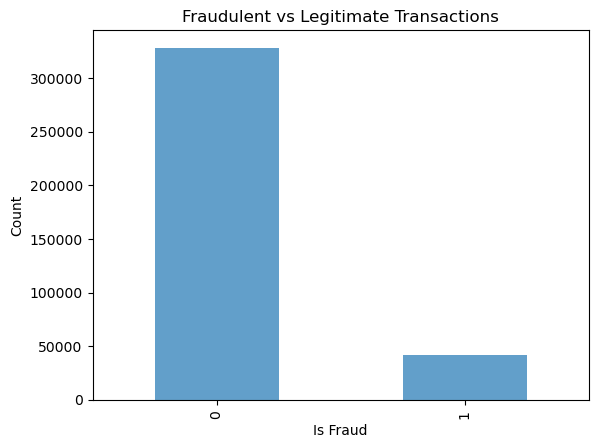

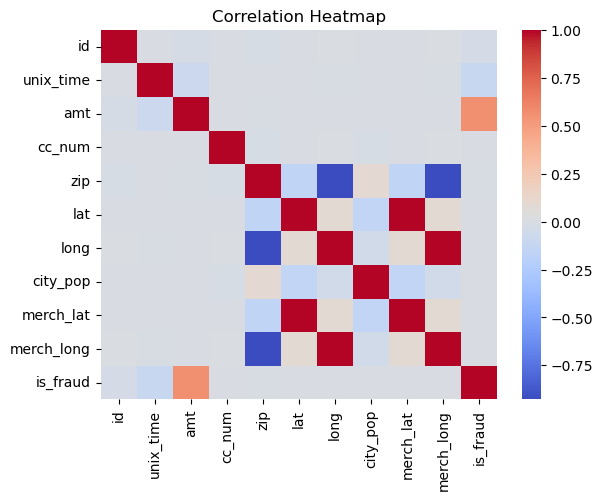

In [1]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from imblearn.over_sampling import SMOTE

# Load datasets
tqdm.pandas()
trainingSet = pd.read_csv("train.csv")
testingSet = pd.read_csv("test.csv")

# Check shapes
print("Train dataset shape: ", trainingSet.shape)
print("Test dataset shape: ", testingSet.shape)

# Check for null values
print("\nMissing values in train data:\n", trainingSet.isnull().sum())
print("\nMissing values in test data:\n", testingSet.isnull().sum())

# Visualize target variable distribution
trainingSet['is_fraud'].value_counts().plot(kind='bar', alpha=0.7)
plt.title("Fraudulent vs Legitimate Transactions")
plt.xlabel("Is Fraud")
plt.ylabel("Count")
plt.show()

# Explore correlations (if numeric)
numeric_columns = trainingSet.select_dtypes(include=[np.number])
correlations = numeric_columns.corr()
sns.heatmap(correlations, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [2]:
# Feature engineering function
def process_features(data):
    df = data.copy()
    
    # Convert transaction datetime
    df['transaction_datetime'] = pd.to_datetime(df['trans_date'] + ' ' + df['trans_time'])
    
    # Extract date and time features
    df['hour'] = df['transaction_datetime'].dt.hour
    df['day_of_week'] = df['transaction_datetime'].dt.dayofweek
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    
    # Calculate age
    df['dob'] = pd.to_datetime(df['dob'])
    df['age'] = (df['transaction_datetime'] - df['dob']).dt.days // 365
    
    # Log transformation for 'amt'
    df['log_amt'] = np.log1p(df['amt'])
    
    # High amount flag
    amt_threshold = df['amt'].quantile(0.99)
    df['high_amt_flag'] = (df['amt'] > amt_threshold).astype(int)
    
    # Geographic distance
    df['distance_from_home'] = df.apply(
        lambda row: geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).kilometers, axis=1
    )
    
    # Drop unnecessary columns
    df.drop(['trans_date', 'trans_time', 'dob', 'transaction_datetime'], axis=1, inplace=True)
    
    return df

# Apply feature engineering to all datasets
trainingSet = process_features(trainingSet)
testingSet = process_features(testingSet)


In [3]:
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score, make_scorer
from imblearn.over_sampling import SMOTE
from scipy.sparse import csr_matrix

# Split data into features and target
X = trainingSet.drop(['is_fraud'], axis=1)
y = trainingSet['is_fraud']

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Identify categorical and numeric columns
categorical_columns = X.select_dtypes(include=['object']).columns
numeric_columns = X.select_dtypes(include=[np.number]).columns

# Combine datasets for consistent preprocessing
combined_data = pd.concat([X_train, X_val, testingSet], axis=0)

# Fit the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_columns),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_columns),
    ]
)
preprocessor.fit(combined_data)

# Transform datasets
X_train_processed = csr_matrix(preprocessor.fit_transform(X_train))
X_val_processed = csr_matrix(preprocessor.transform(X_val))
test_processed = csr_matrix(preprocessor.transform(testingSet))

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Define the LightGBM model
lgb_model = LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=300,
    max_depth=-1,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(y_train_resampled) / sum(y_train_resampled),
    random_state=42,
    n_jobs=-1  
)

In [4]:
# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score)
scores = cross_val_score(lgb_model, X_train_resampled, y_train_resampled, cv=cv, scoring=f1_scorer)
print("Cross-validation F1 scores:", scores)
print("Mean CV F1 Score:", np.mean(scores))

# Final training
lgb_model.fit(X_train_resampled, y_train_resampled)


[LightGBM] [Info] Number of positive: 197042, number of negative: 197042
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 6.106050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 303699
[LightGBM] [Info] Number of data points in the train set: 394084, number of used features: 20426
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 197043, number of negative: 197042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 6.548688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 304059
[LightGBM] [Info] Number of data points in the train set: 394085, number of used features: 20388
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000005
[LightGBM] [Info] Start training from scor

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, n_estimators=300,
               n_jobs=-1, random_state=42, scale_pos_weight=2.0, subsample=0.8)

Validation F1 Score: 0.9685829503891964


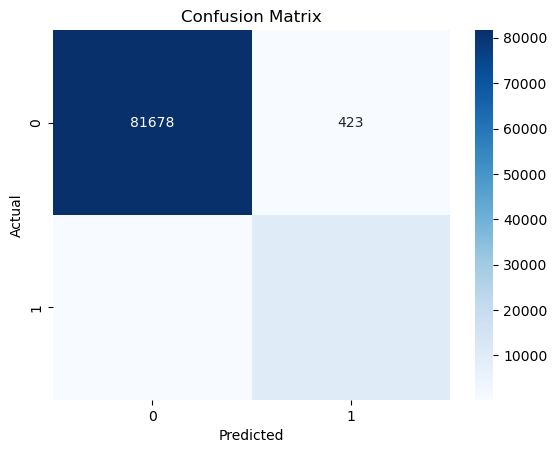

Submission file 'submission.csv' created successfully.


In [5]:
# Evaluate on validation data
y_pred_val = lgb_model.predict(X_val_processed)
f1 = f1_score(y_val, y_pred_val)
print("Validation F1 Score:", f1)

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_val)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Predict on test data
y_test_pred = lgb_model.predict(test_processed)

# Create submission file
submission = pd.DataFrame({
    'id': testingSet['id'],  # Ensure 'id' column exists in the test data
    'is_fraud': y_test_pred
})
submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully.")
